In [8]:
import yaml
import numpy as np
import zstandard as zstd
import os
from OptimumFilter import *
from TraceSimulator import LongTraceSimulator
import matplotlib.pyplot as plt
from trace_IO import *
def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict
sampling_frequency = 3906250
vac_template = np.load("templates/vac_ch_template.npy")
sub_template = np.load("templates/sub_ch_template.npy")
noise_psd = np.load("../../templates/noise_psd_from_MMC.npy")
config = read_yaml_to_dict('/home/dwong/DELight_mtr/trigger_study/archive/wk11/config.yaml')
lts = LongTraceSimulator(config)
vac_of = OptimumFilter(vac_template, noise_psd, sampling_frequency)
sub_of = OptimumFilter(sub_template, noise_psd, sampling_frequency)

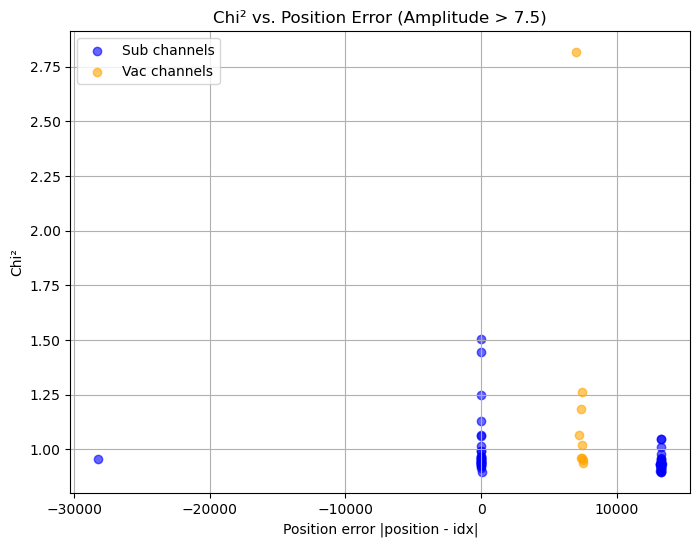

In [17]:
trace, idx= lts.generate(
            E=7000,
            x=-94, y=0, z=-1800,
            no_noise=False,
            type_recoil='ER',
            quantize=True,
            phonon_only=False
        )
trace = trace[0]
amps = []
chisqs = []
shifts = []
positions = []
significant_fits = []
channels = []
all_fit_results = []

# These are for plotting
sub_deltas = []
sub_chisqs = []
vac_deltas = []
vac_chisqs = []

for ch in range(54):
    if ch < 45:
        ampl, chisq, shift, position = sub_of.rolling_fit_with_shift(trace[ch], allowed_shift_range=[0, 32767])
    else:
        ampl, chisq, shift, position = vac_of.rolling_fit_with_shift(trace[ch], allowed_shift_range=[0, 32767])
    
    # Store raw arrays
    amps.append(ampl)
    chisqs.append(chisq)
    shifts.append(shift)
    positions.append(position)
    
    # Store per-channel fits for later analysis
    fit_results = [
        {'channel': ch, 'amplitude': a, 'shift': s, 'chisq': c, 'position': p}
        for a, s, c, p in zip(ampl, shift, chisq, position)
    ]
    all_fit_results.extend(fit_results)

    # Filter significant amplitudes
    for res in fit_results:
        if res['amplitude'] > 7.5:
            significant_fits.append(res)
            channels.append(ch)
            delta = (res['position']-idx) 
            if ch < 45:
                sub_deltas.append(delta)
                sub_chisqs.append(res['chisq'])
            else:
                vac_deltas.append(delta)
                vac_chisqs.append(res['chisq'])

# ---- Plot ----
plt.figure(figsize=(8, 6))
plt.scatter(sub_deltas, sub_chisqs, alpha=0.6, label='Sub channels', color='blue')
plt.scatter(vac_deltas, vac_chisqs, alpha=0.6, label='Vac channels', color='orange')
plt.xlabel("Position error |position - idx|")
plt.ylabel("Chi²")
plt.title("Chi² vs. Position Error (Amplitude > 7.5)")
plt.grid(True)
plt.legend()
plt.show()


In [18]:
print("=== Fits with |position - idx| > 5000 and amplitude > 4 ===")
for res in all_fit_results:
    pos_error = res['position'] - idx
    amp = res['amplitude']
    ch = res['channel']
    chisq = res['chisq']
    shift_val = res['shift']  # <- Extract the shift here

    if amp > 4:
        # Check if any other fit in the same channel (excluding this one) has amp > 4
        other_fits = [r for r in all_fit_results if r['channel'] == ch and r != res]
        has_other_significant = any(r['amplitude'] > 4 for r in other_fits)

        print(f"Channel {ch} | Amplitude: {amp:.2f}, Chi²: {chisq:.2f}, Error: {pos_error}, Shift: {shift_val}, Other fit passed?: {has_other_significant}")


=== Fits with |position - idx| > 5000 and amplitude > 4 ===
Channel 0 | Amplitude: 48.49, Chi²: 0.93, Error: -2, Shift: 16341, Other fit passed?: True
Channel 0 | Amplitude: 16.24, Chi²: 0.91, Error: 13256, Shift: -3169, Other fit passed?: True
Channel 2 | Amplitude: 69.37, Chi²: 0.96, Error: -11, Shift: 16332, Other fit passed?: True
Channel 2 | Amplitude: 21.01, Chi²: 0.93, Error: 13251, Shift: -3174, Other fit passed?: True
Channel 3 | Amplitude: 46.28, Chi²: 0.94, Error: -4, Shift: 16339, Other fit passed?: True
Channel 3 | Amplitude: 14.91, Chi²: 0.91, Error: 13229, Shift: -3196, Other fit passed?: True
Channel 4 | Amplitude: 51.97, Chi²: 0.94, Error: 1, Shift: 16344, Other fit passed?: True
Channel 4 | Amplitude: 15.18, Chi²: 0.92, Error: 13259, Shift: -3166, Other fit passed?: True
Channel 5 | Amplitude: 85.66, Chi²: 0.96, Error: -6, Shift: 16337, Other fit passed?: True
Channel 5 | Amplitude: 29.08, Chi²: 0.94, Error: 13241, Shift: -3184, Other fit passed?: True
Channel 7 | Amp

In [14]:
idx

400131

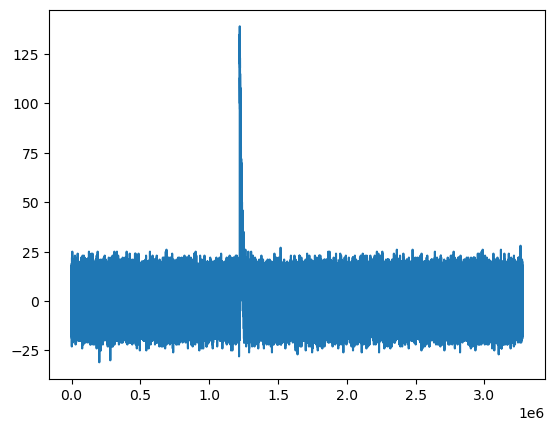

In [34]:
plt.plot(trace[0])

In [35]:
ampl, chisq, shift, position = sub_of.rolling_fit_with_shift(trace[0])


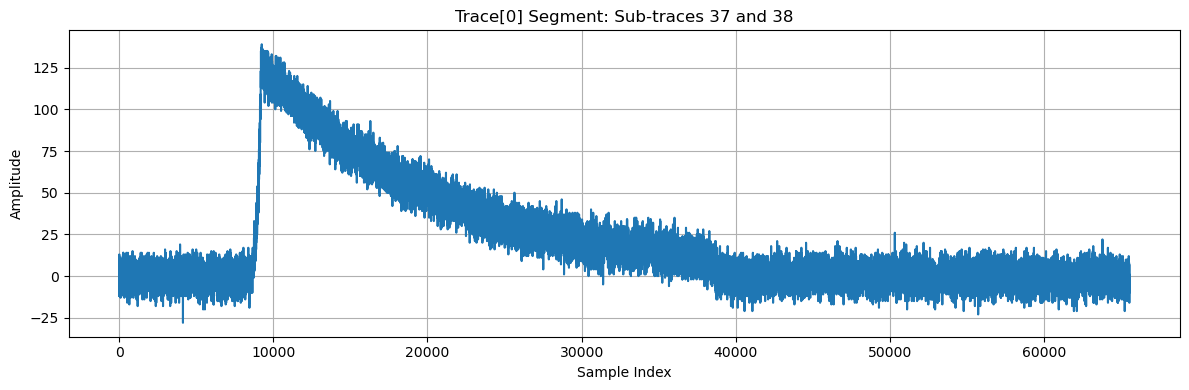

In [38]:
import matplotlib.pyplot as plt

# Constants
segment_len = 32768
start_idx = 37 * segment_len
end_idx = 39 * segment_len  # includes index 37 and 38

# Slice the desired segment
segment = trace[0][start_idx:end_idx]

# Plot it
plt.figure(figsize=(12, 4))
plt.plot(segment)
plt.title("Trace[0] Segment: Sub-traces 37 and 38")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


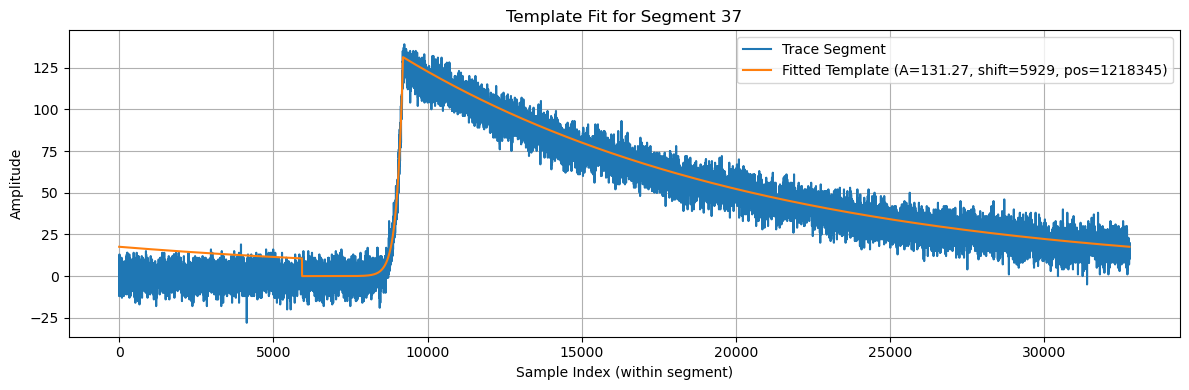

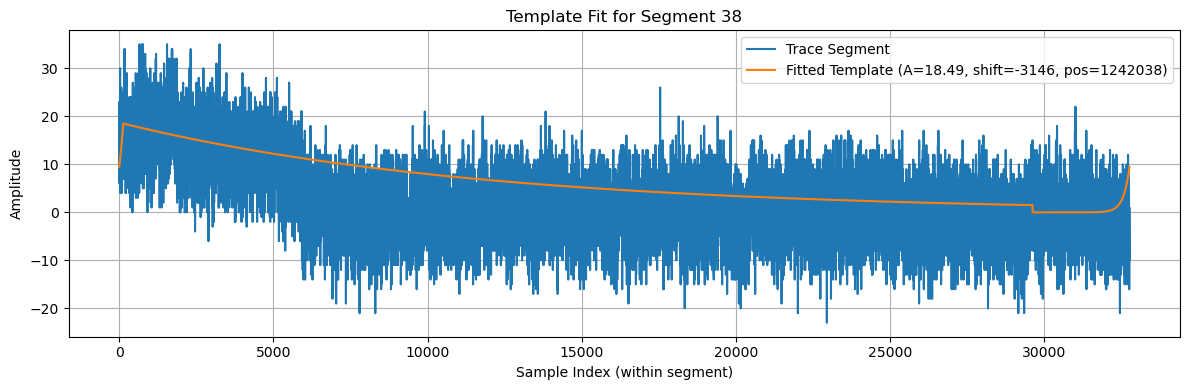

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Load template
sub_template = np.load("templates/sub_ch_template.npy")

# Run the fit
ampl, chisq, shift, position = sub_of.rolling_fit_with_shift(trace[0])

# Constants
segment_len = 32768
trace_data = trace[0]

for idx in [37, 38]:
    # Get fitting parameters
    A = ampl[idx]
    s = shift[idx]        # integer shift (can be positive or negative)
    pos = position[idx]   # absolute fit position (in full trace)

    # Extract raw data segment
    start = idx * segment_len
    end = start + segment_len
    data_segment = trace_data[start:end]

    # Shift template appropriately (zero-padding if needed)
    shifted_template = np.roll(sub_template, s)

    # If desired, you could zero out the parts that are invalid due to roll
    # For example:
    # if s > 0:
    #     shifted_template[:s] = 0
    # elif s < 0:
    #     shifted_template[s:] = 0

    # Scale template
    fitted_template = A * shifted_template

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(data_segment, label='Trace Segment')
    plt.plot(fitted_template, label=f'Fitted Template (A={A:.2f}, shift={s}, pos={pos})')
    plt.title(f"Template Fit for Segment {idx}")
    plt.xlabel("Sample Index (within segment)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
